In [23]:
%load_ext autoreload
%autoreload 2

from dataclasses import dataclass
import os
import math
import sys
from typing import Dict, Any, List, Optional
sys.path.append('../../../../')

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import numpy as np
import pandas as pd

from matplotlib.ticker import FuncFormatter

from multitask_nlp.utils.plotting import Task, get_overall_score, visualize_boxplot, human_format

color_pallette = 'muted'
sns.set_theme(style='whitegrid', context='talk', palette=color_pallette, 
              rc={'font.family': 'serif', 'font.serif': 'Times New Roman', 'mathtext.fontset': 'dejavuserif'})

tasks = [
    Task(name='BoolQ', measure='macro_f1_label', 
         measure_name='Macro F1', size=6927),
    Task(name='CommitmentBank', short_name='CB', measure='macro_f1_label', 
         measure_name='Macro F1', size=200),
    Task(name='GoEmotions', short_name='GoEmo', measure='macro_f1_mean', 
         measure_name='Macro F1', size=34806),
    Task(name='MeasuringHateSpeech', short_name='MHS', measure='r2_hate_speech_score', 
         measure_name='R2', size=23739),
    Task(name='Multiemo', measure='macro_f1_sentiment', 
         measure_name='Macro F1', size=6572),
    Task(name='MultiRC', measure='macro_f1_label', 
         measure_name='Macro F1', size=22275),
    Task(name='RTE', measure='macro_f1_label', 
         measure_name='Macro F1', size=2190),
    Task(name='SciTail', measure='macro_f1_label', 
         measure_name='Macro F1', size=23097),
    Task(name='SNLI', measure='macro_f1_label', 
         measure_name='Macro F1', size=549361),
    Task(name='SST-2', measure='macro_f1_label', 
         measure_name='Macro F1', size=66449),
    Task(name='STS-B', measure='r2_label', 
         measure_name='R2', size=4249)  
]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
for task in tasks:
    print(task.name, end='')
    if task.short_name is not None:
        print(f' ({task.short_name}), ', end='')
    else:
        print(', ', end='')

BoolQ, CommitmentBank (CB), GoEmotions (GoEmo), MeasuringHateSpeech (MHS), Multiemo, MultiRC, RTE, SciTail, SNLI, SST-2, STS-B, 

In [5]:
def get_type(row):
    ttype = row['learning_kind']
    if not pd.isna(row['mt_dataset_type']):
        ttype += '_' + str(row['mt_dataset_type'])
        if row['mt_dataset_type'] == 'proportional_sampling':
            ttype += r'_$\alpha={}$'.format(row['alpha'])
        
    return ttype


def load_results_df(file_path: str):
    df = pd.read_csv(file_path)
    df['type'] = df.apply(lambda x: get_type(x), axis=1)
    df['overall_score'] = df.apply(lambda x: get_overall_score(x, tasks=tasks), axis=1)
    df['weighted_overall_score'] = df.apply(lambda x: get_overall_score(x, tasks=tasks, weighted=True), axis=1)
    
    for scale_class_loss in df['scale_class_loss'].unique():
        df1 = df[(df['learning_kind'] == 'STL') & (df['scale_class_loss'] == scale_class_loss)]

        stl_results = {}
        for task_name in df1.dataset.unique():
            for task in tasks:
                if task_name == task.name:
                    col_measure = f'{task.name}_test_{task.measure}'
                    stl_results[task.name] = df1[df1.dataset == task.name][col_measure].values, task.size

        total_size = sum([task.size for task in tasks])
        overall_results = sum([v[0] for v in stl_results.values()]) / len(tasks)
        weighted_overall_results = sum([v[1]*v[0] for v in stl_results.values()]) / total_size


        records = [{'type': 'STL', 'scale_class_loss': scale_class_loss, 'overall_score': r1,
                    'weighted_overall_score': r2}
                   for r1, r2 in zip(overall_results, weighted_overall_results)]
        df = pd.concat([df, pd.DataFrame(records)], ignore_index=True) 

    return df

In [6]:
def format_score(x):
    if x == 0:
        return '00.00'
    else:
        return f'{round(100*x, 2):.2f}'

In [7]:
# df.columns.values

In [8]:
df = load_results_df('mtl_plus_results.csv')

In [9]:
df[['batch_size', 'learning_rate', 'max_length', 'model_name', 'model_type', 'mt_dataset_type', 
    'num_epochs', 'scale_class_loss', 'warmup_proportion', 'weight_decay', 'alpha', 'steps']].drop_duplicates()

,batch_size,learning_rate,max_length,model_name,model_type,mt_dataset_type,num_epochs,scale_class_loss,warmup_proportion,weight_decay,alpha,steps
0,32.0,0.00001,128.0,bert,multitask_transformer,annealing_sampling,4.0,log,0.1,0.01,NaN,5000.0
1,32.0,0.00001,128.0,bert,multitask_transformer,proportional_sampling,4.0,log,0.1,0.01,0.75,5000.0
2,32.0,0.00001,128.0,bert,multitask_transformer,sampling,4.0,log,0.1,0.01,NaN,5000.0
3,32.0,0.00001,128.0,bert,multitask_transformer,round_robin,4.0,log,0.1,0.01,NaN,NaN
4,32.0,0.00001,128.0,bert,multitask_transformer,NaN,4.0,log,0.1,0.01,NaN,NaN
45,32.0,0.00001,128.0,bert,multitask_transformer,annealing_sampling,4.0,linear,0.1,0.01,NaN,5000.0
46,32.0,0.00001,128.0,bert,multitask_transformer,proportional_sampling,4.0,linear,0.1,0.01,0.75,5000.0
47,32.0,0.00001,128.0,bert,multitask_transformer,sampling,4.0,linear,0.1,0.01,NaN,5000.0
48,32.0,0.00001,128.0,bert,multitask_transformer,round_robin,4.0,linear,0.1,0.01,NaN,NaN
49,32.0,0.00001,128.0,bert,multitask_transformer,NaN,4.0,linear,0.1,0.01,NaN,NaN


In [320]:
# with pd.option_context('display.max_rows', None):
#     display(df[['dataset', 'type', 'BoolQ_test_macro_f1_label', 'overall_score']])

In [321]:
# with pd.option_context('display.max_rows', None):
#     display(df[['dataset', 'type', 'scale_class_loss', 'epoch', 'num_epochs', 'trainer/global_step', 'Runtime']])

In [12]:
type_order = ['STL', 'MTL_round_robin', 'MTL_sampling', 'MTL_proportional_sampling_$\\alpha=0.75$', 
         'MTL_annealing_sampling']

scaling_type_order = ['none', 'linear', 'log']
    
order = [(t, st) for t in type_order for st in scaling_type_order]
    
    
agg_dict = {task.short_name if task.short_name is not None else task.name:
            (f'{task.name}_test_{task.measure}', 'mean') for task in tasks}

agg_dict.update({
    'Overall': (f'overall_score', 'mean'),
    'Weighted Overall': (f'weighted_overall_score', 'mean') 
})

result_df = df.groupby(['type', 'scale_class_loss']).agg(**agg_dict)

for col in agg_dict.keys():
    result_df[col] = result_df[col].apply(lambda x: format_score(x))
    
result_df = result_df.T
result_df = result_df[order]

result_df = result_df.rename(columns={c: ' '.join(c.split('_')) for c in result_df.columns.levels[0]}, level=0)
result_df = result_df.rename(columns={c: c.capitalize() for c in result_df.columns.levels[1]}, level=1)

In [13]:
result_df

type                STL               MTL round robin                \
scale_class_loss   None Linear    Log            None Linear    Log   
BoolQ             59.26  59.44  61.16           62.09  65.57  65.69   
CB                35.12  35.12  35.12           52.48  54.11  55.02   
GoEmo             61.25  61.24  61.26           67.01  52.73  60.64   
MHS               60.39  60.39  60.39           43.63  52.32  46.78   
Multiemo          81.16  81.16  81.12           81.67  82.36  82.11   
MultiRC           65.58  65.41  65.52           64.58  65.87  65.95   
RTE               59.58  59.23  59.34           72.74  75.06  74.94   
SciTail           88.53  88.43  88.56           89.68  89.70  89.65   
SNLI              90.40  90.39  90.35           90.42  90.28  90.35   
SST-2             91.28  91.24  91.35           90.89  91.62  91.55   
STS-B             72.20  72.20  72.20           64.38  70.55  67.05   
Overall           69.52  69.48  69.67           70.87  71.83  71.79   
Weighted Overall  86.75  86.74  86.74           86.50  86.20  86.41   

type             MTL sampling                \
scale_class_loss         None Linear    Log   
BoolQ                   67.79  65.68  66.99   
CB                      66.20  66.65  66.59   
GoEmo                   59.12  49.43  52.05   
MHS                     39.90  50.33  43.98   
Multiemo                83.06  83.05  82.43   
MultiRC                 64.20  63.94  65.02   
RTE                     71.23  69.92  72.84   
SciTail                 88.61  87.87  87.09   
SNLI                    83.01  81.50  81.72   
SST-2                   89.90  90.82  90.63   
STS-B                   66.12  68.88  67.20   
Overall                 70.83  70.74  70.60   
Weighted Overall        80.45  79.25  79.34   

type             MTL proportional sampling $\alpha=0.75$                \
scale_class_loss                                    None Linear    Log   
BoolQ                                              52.27  57.24  58.31   
CB                                                 51.80  52.67  51.43   
GoEmo                                              56.78  49.47  52.80   
MHS                                                37.85  50.47  45.08   
Multiemo                                           80.84  81.07  79.84   
MultiRC                                            59.77  63.34  63.55   
RTE                                                72.37  72.23  71.67   
SciTail                                            88.35  88.73  89.37   
SNLI                                               88.21  88.32  88.09   
SST-2                                              90.43  91.32  91.32   
STS-B                                              60.36  68.43  64.05   
Overall                                            67.18  69.39  68.68   
Weighted Overall                                   83.84  84.28  84.09   

type             MTL annealing sampling                
scale_class_loss                   None Linear    Log  
BoolQ                             57.59  62.67  62.60  
CB                                56.06  63.47  56.77  
GoEmo                             57.14  49.56  52.72  
MHS                               39.10  49.64  43.46  
Multiemo                          82.20  81.65  81.57  
MultiRC                           59.19  63.76  63.31  
RTE                               73.55  74.97  74.60  
SciTail                           89.01  89.77  89.21  
SNLI                              88.10  88.10  88.02  
SST-2                             90.09  91.54  91.54  
STS-B                             64.48  69.76  65.57  
Overall                           68.77  71.35  69.94  
Weighted Overall                  83.88  84.24  84.06

In [14]:
result_df.to_csv(f'mtl_plus_agg_results.csv', index=True)

In [15]:
df['type'].unique()

array(['MTL_annealing_sampling',
       'MTL_proportional_sampling_$\\alpha=0.75$', 'MTL_sampling',
       'MTL_round_robin', 'STL'], dtype=object)

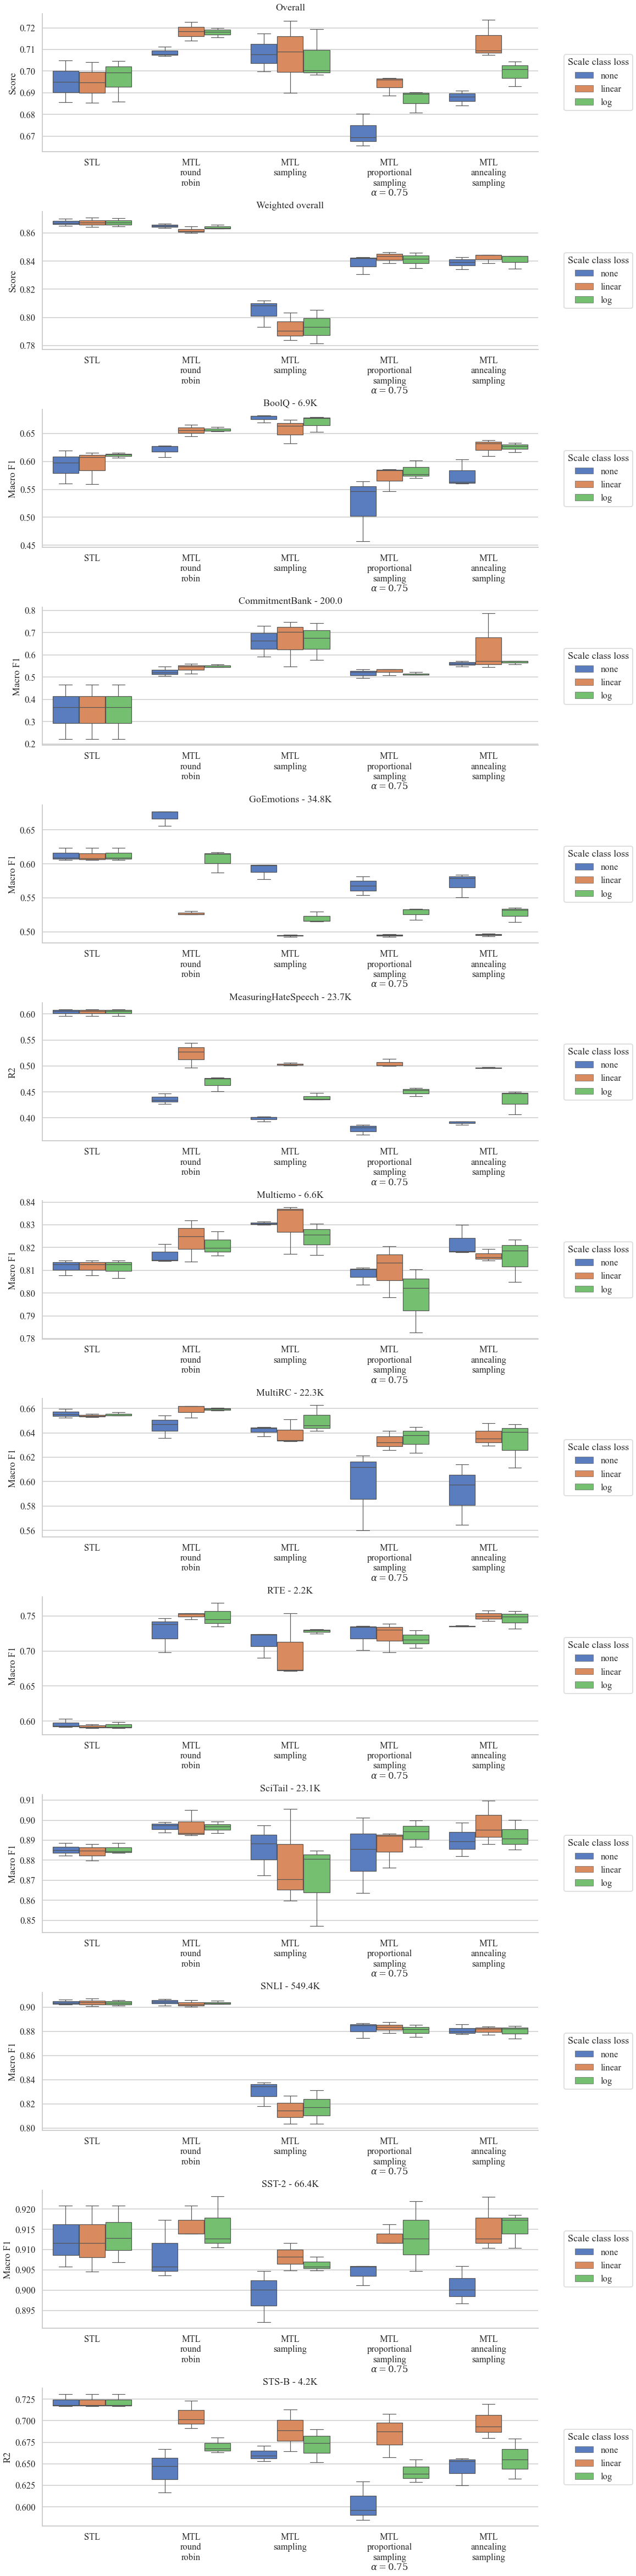

In [20]:
order = ['STL', 'MTL_round_robin', 'MTL_sampling', 'MTL_proportional_sampling_$\\alpha=0.75$', 
         'MTL_annealing_sampling']

hue_order=['none', 'linear', 'log']

visualize_boxplot(
    df, tasks=tasks,
    cols=1, row_height=5, fig_width=16, all_tasks=True,
    savefig=False, filename='mtl_plus_full_results_plot',
    showfliers=True, linewidth=1.2, order=order, 
    hue='scale_class_loss', 
    hue_order=hue_order,
    ncol=1, loc='center right', bbox_to_anchor=(1.20, 0.5), only_fig_legend=False,
    runtimes=False, steps=False, 
)

In [21]:
from collections import defaultdict

sizes = []
task_names = []

gain_results = defaultdict(lambda: defaultdict(list))

for task in tasks:
    sizes.append(task.size)
    
    if task.short_name is not None:
        task_names.append(task.short_name)
    else:
        task_names.append(task.name)
        
    measure_col = f'{task.name}_test_{task.measure}'
    
    task_df = df.dropna(subset=['dataset'])
    task_df = task_df[task_df['dataset'].str.contains(task.name)]
    df_grouped = task_df.groupby(['scale_class_loss', 'type'], as_index=False).mean()
    
    for scale_class_loss in ['none', 'linear', 'log']:
        df_grouped_loss = df_grouped[df_grouped.scale_class_loss == scale_class_loss]
        
        stl_measure = df_grouped_loss[df_grouped_loss.type == 'STL'][measure_col].values[0]
        for t in ['MTL_round_robin', 'MTL_sampling', 'MTL_proportional_sampling_$\\alpha=0.75$', 
         'MTL_annealing_sampling']:
            
            t_string = t.replace('_', ' ')
            if 'proportional' in t_string:
                t_string = t_string.replace('proportional ', 'proportional\n')
            if t != 'STL':
                mtl_measure = df_grouped_loss[df_grouped_loss.type == t][measure_col].values[0]
                mtl_gain = mtl_measure - stl_measure
                
                gain_results[scale_class_loss][t_string].append(mtl_gain)

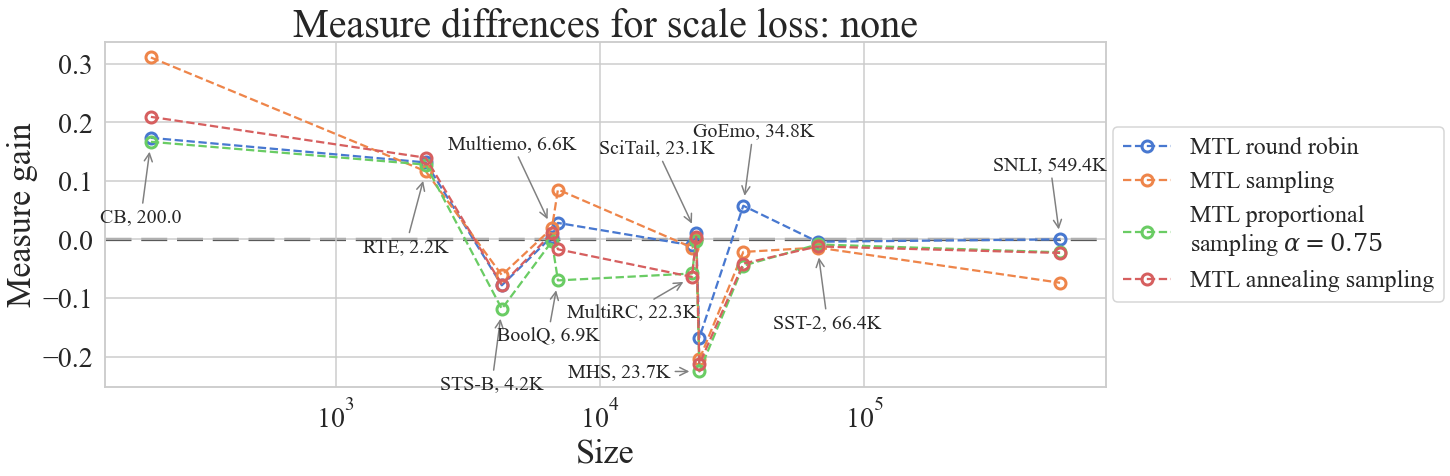

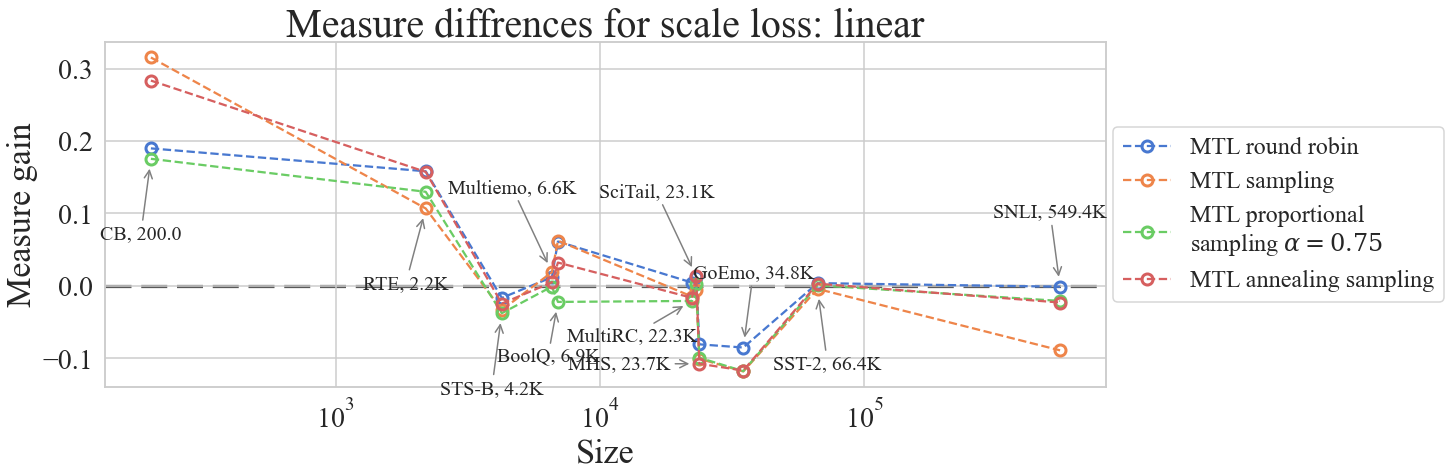

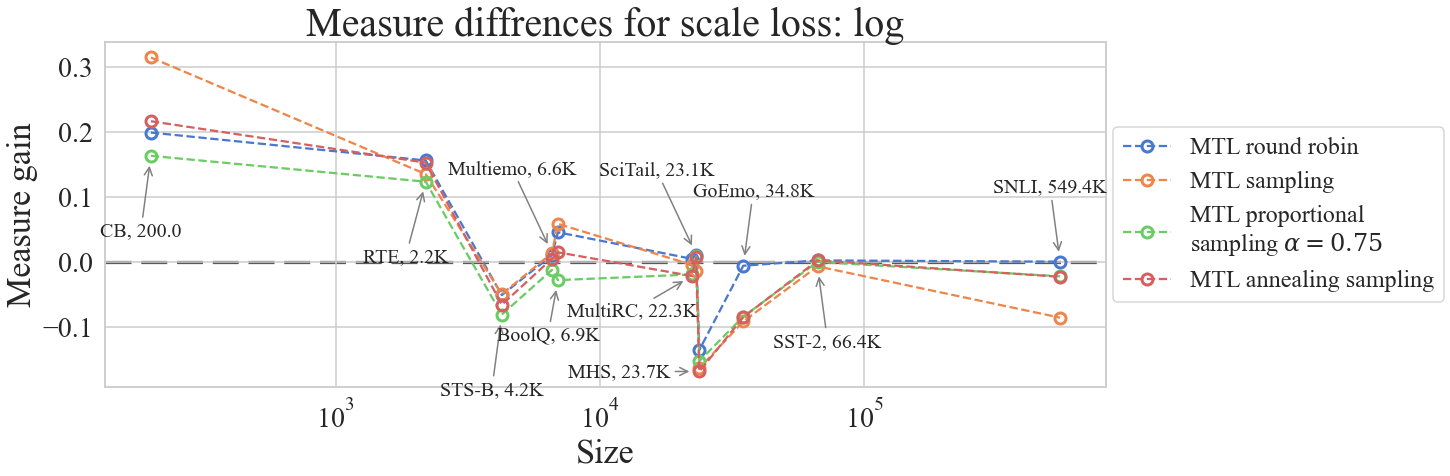

In [24]:
figwidth = 20
figheight = 6.5

sizes = np.array(sizes)
task_names = np.array(task_names)
sorted_indices = np.argsort(sizes)

sorted_sizes = sizes[sorted_indices]
sorted_task_names = task_names[sorted_indices]

rows =len(gain_results)

max_pos_task = ['Multiemo', 'SciTail', 'GoEmo', 'SNLI']

default_offset = (-10, -80)

special_text_offset = {
    'BoolQ': (-10, -60),
    'Multiemo': (-40, 80),
    'SciTail': (-40, 80),
    'MultiRC': (-60, -40),
    'GoEmo': (10, 70),
    'RTE': (-20, -80),
    'MHS': (-80, -5),
    'SST-2': (10, -80),
    'SNLI': (-10, 70),
}

for loss, gains in gain_results.items():
    
    fig, ax = plt.subplots(figsize=(figwidth, figheight), constrained_layout=True)
    
    for mtl_type, mtl_gains in gains.items():    
        mtl_gains = np.array(mtl_gains)
        ax.plot(sorted_sizes, mtl_gains[sorted_indices], '--.', label=mtl_type, ms=22, mew=3, mfc='none')
    
    ax.set_xscale('log')    
    ax.legend(fontsize=24, loc='center right', bbox_to_anchor=(1.35, 0.5))
    ax.set_title(f'Measure diffrences for scale loss: {loss}', fontsize=40)
    ax.set_xlabel('Size', fontsize=34)
    ax.set_ylabel('Measure gain', fontsize=34)
    ax.tick_params(axis='x', labelsize=28)
    ax.tick_params(axis='y', labelsize=28)
    
    for i, (task_name, task_size) in enumerate(zip(sorted_task_names, sorted_sizes)):
        if task_name in max_pos_task:
            y = max([line.get_data()[1][i] for line in ax.lines])
        else:
            y = min([line.get_data()[1][i] for line in ax.lines])
            
        annot_text = task_name + ', ' + human_format(task_size)     
        if task_name in special_text_offset.keys():
            xytext = special_text_offset[task_name]
        else:
            xytext = default_offset
        
        ax.annotate(
            annot_text, xy=(task_size, y), xytext=xytext, textcoords='offset points', ha='center', fontsize=20,
            arrowprops=dict(arrowstyle="->", color="grey", shrinkB=10) 
        )
        
    ax.axhline(y=0, alpha=0.75, color='#222222', ls=(0, (8, 3)), lw=3.25, zorder=-1)
    
    fig.savefig(f'mtl_plus_score_vs_size_{loss}.pdf', bbox_inches='tight')